In [19]:
"""
"Simple GLM analysis in R" fMRI tutorial in Coursera course fmri003
https://class.coursera.org/fmri-003/wiki/Simple_GLM_analysis_in_R

To run this tutorial, download data and unzip into this directory.
https://d396qusza40orc.cloudfront.net/fmri/MoAEpilot_preproc.zip
"""
# Created by: Ben Cipollini <bcipolli@ucsd.edu>

import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import tempfile

import nibabel
from nilearn.image import index_img
from nipy.modalities.fmri import design_matrix
from nipy.modalities.fmri.experimental_paradigm import BlockParadigm
from nipy.modalities.fmri.glm import FMRILinearModel
from nipy.labs.viz import plot_map, cm
from nilearn.plotting import plot_stat_map as plot_map


########################################
# Load the data
########################################
myfile = 'C:\\Users\\JT\\Desktop\\GitHub\\coursera-fmri003-python\\tutorial2.py'

%matplotlib inline

# Input the functional volume
print("Loading all functional images into a single volume...")
data_dir = os.path.join(os.path.dirname(myfile),
                        'MoAEpilot_preproc', 'fM00223')
search_string = os.path.join(data_dir, 'swrfM00223_*.img')
all_files = glob.glob(search_string)

print len(all_files)

# Convert from Analyze format to NiImg format to avoid errors later.
func_filename = tempfile.mkstemp()[1] + '.nii'  # temp filename
func_img = nibabel.funcs.concat_images(all_files)
nibabel.save(func_img, func_filename)
func_img = nibabel.load(func_filename)

# Images start with 004, so slice is unnecessary.
# func_img = index_img(func_img, slice(4))  # eliminate images 1-4



Loading all functional images into a single volume...
96


[   0.    1.    2.    3.    4.    5.   13.   14.   15.   16.   17.   18.
   26.   27.   28.   29.   30.   31.   39.   40.   41.   42.   43.   44.
   52.   53.   54.   55.   56.   57.   65.   66.   67.   68.   69.   70.
   78.   79.   80.   81.   82.   83.   91.   92.   93.   94.   95.   96.
  104.  105.  106.  107.  108.  109.  117.  118.  119.  120.  121.  122.
  130.  131.  132.  133.  134.  135.  143.  144.  145.  146.  147.  148.
  156.  157.  158.  159.  160.  161.  169.  170.  171.  172.  173.  174.
  182.  183.  184.  185.  186.  187.  195.  196.  197.  198.  199.  200.]
[   0.   13.   26.   39.   52.   65.   78.   91.  104.  117.  130.  143.
  156.  169.  182.  195.]
Fitting a GLM (this takes time)...
Beta image witten in beta.nii


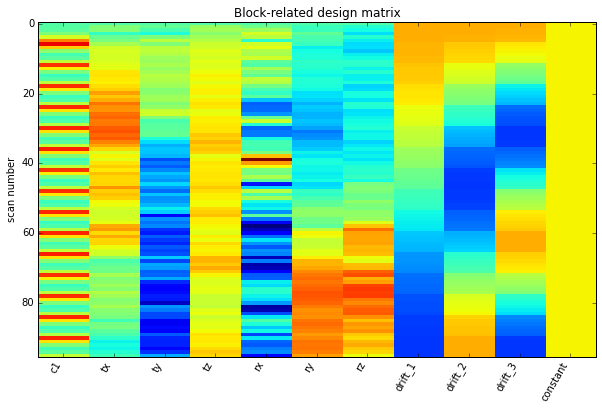

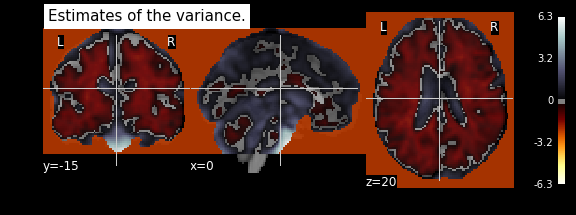

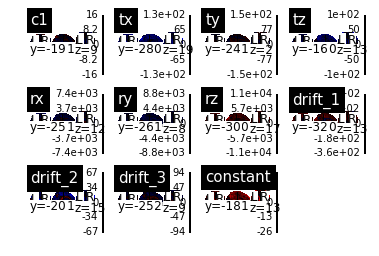

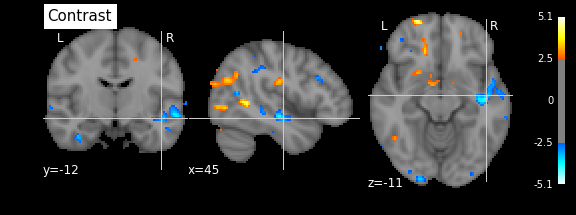

In [20]:

########################################
# Create the design matrix
########################################
# From http://cogmaster-stats.github.io/python-cogstats/auto_examples/plot_localizer_analysis.html
# and https://github.com/nipy/nipy/blob/master/examples/labs/demo_dmtx.py

n_scans = 96
n_blocks = 16
tr = 7  # s

frametimes = np.ones((n_scans,))
con_id = np.ones((n_blocks,))  # 1=stimulation
duration = 7 * np.ones((n_blocks,))
onset = np.ones((n_blocks,))
for bi in range(n_blocks):
    onset[bi] = 0 + 13 * bi

    frametimes_idx = np.arange(6) + bi * 6
    frametimes_times = np.arange(6) + bi * 13
    frametimes[frametimes_idx] = frametimes_times
print frametimes
print onset
paradigm = BlockParadigm(con_id=con_id, onset=onset, duration=duration)

motion_file = os.path.join(data_dir, 'motion.txt')
def parse_motion(motion_file):
    with open(motion_file, 'rb') as fp:
        data = fp.readlines()
    data2 = [float(v.strip()) for l in data for v in l.split(' ') if v != '']
    data3 = np.asarray(data2).reshape(96, 6)
    return data3
motion_data = parse_motion(motion_file)
motion_params = ['tx', 'ty', 'tz', 'rx', 'ry', 'rz']

dmat = design_matrix.make_dmtx(frametimes, paradigm=paradigm,
                               hrf_model='canonical',
                               drift_model='cosine', drift_order=2,  # quadratic
                               add_regs=motion_data, add_reg_names=motion_params)

# plot the design matrix
fig = plt.figure(figsize=(10, 6))
ax = fig.gca()
dmat.show(ax=ax)
ax.set_title('Block-related design matrix', fontsize=12)

########################################
# Perform a GLM analysis
########################################
# From https://github.com/nipy/nipy/blob/master/examples/labs/need_data/glm_beta_and_variance.py
print('Fitting a GLM (this takes time)...')
fmri_glm = FMRILinearModel(func_img, dmat.matrix,
                           mask='compute')
fmri_glm.fit(do_scaling=True, model='ar1')


########################################
# Output beta and variance images
########################################

beta_hat = fmri_glm.glms[0].get_beta()  # Least-squares estimates of the beta
variance_hat = fmri_glm.glms[0].get_mse()  # Estimates of the variance
mask = fmri_glm.mask.get_data() > 0

# output beta images
dim = dmat.matrix.shape[1]
beta_map = np.tile(mask.astype(np.float)[..., np.newaxis], dim)
beta_map[mask] = beta_hat.T
beta_image = nibabel.Nifti1Image(beta_map, fmri_glm.affine)
beta_image.get_header()['descrip'] = (
    'Parameter estimates of the localizer dataset')
output_file = 'beta.nii'
nibabel.save(beta_image, output_file)
print("Beta image witten in %s" % output_file)

variance_map = mask.astype(np.float)
variance_map[mask] = variance_hat

# Create a snapshots of the variance image contrasts
vmax = np.log(variance_hat.max())
# plot_map(func_img.get_data()[..., 0], func_img.affine, title='Original data (t=0)')
var_image = nibabel.Nifti1Image(np.log(variance_map + .1),
                                fmri_glm.affine)
plot_map(var_image,
         cmap=cm.hot_black_bone,
         vmax=vmax,
         threshold=.2, alpha=.9,
         black_bg=True,
         title='Estimates of the variance.')

########################################
# Output all beta images, and time series change
########################################

# Show beta map for each beta
fh = plt.figure()
for pi in range(len(dmat.names)):
    ax = fh.add_subplot(3, 4, pi + 1)
    cur_beta_image = nibabel.Nifti1Image(beta_map[..., pi], fmri_glm.affine)
    plot_map(cur_beta_image, title=dmat.names[pi], axes=ax)

# Define things of interest
z_slice_idx = 39  # 40th image
time_idx = 29  # 30th time point
vox_idx = (19, 19, z_slice_idx)

#########################################
# Estimate the contrasts
#########################################
# From http://cogmaster-stats.github.io/python-cogstats/auto_examples/plot_localizer_analysis.html

z_map, = fmri_glm.contrast(np.ones(11), 1, output_z=True)
vmax = max(-z_map.get_data().min(), z_map.get_data().max())
z_img = nibabel.Nifti1Image(z_map.get_data(), z_map.get_affine())
plot_map(z_img,
         cmap=cm.cold_hot, vmax=vmax,
         black_bg=True, threshold=2.5,
         title='Contrast')
plt.show()
